<a href="https://colab.research.google.com/github/cwattsnogueira/rating-predictor-spam-detection-review-summarizer/blob/main/12_dl_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

## Load Data & Features

In [ ]:
df = pd.read_parquet("/content/engineered_features_with_anomalies.parquet")
structured_features = joblib.load("/content/feature_names_with_anomalies.json")

texts = df['clean_text'].astype(str).values
y = df['fake_review_label'].values

## Tokineze and Pad Text

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_text = pad_sequences(sequences, maxlen=100)

joblib.dump(tokenizer, "/content/tokenizer.pkl")
np.save("/content/text_sequences.npy", X_text)

## Load Structure Feature and Combine Inputs

In [ ]:
X_structured = df[structured_features].values
np.save("/content/X_structured.npy", X_structured)

In [ ]:
from numpy import hstack
X_combined = hstack([X_text, X_structured])
np.save("/content/X_combined.npy", X_combined)

## Train / Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)
np.save("/content/y_fake_review.npy", y)

## Build and Compile Model

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model with Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
csv_logger = CSVLogger("/content/training_log.csv")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, csv_logger]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.8646 - loss: 0.4216 - val_accuracy: 0.9283 - val_loss: 0.2524
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.9206 - loss: 0.2707 - val_accuracy: 0.9283 - val_loss: 0.2358
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - accuracy: 0.9331 - loss: 0.2204 - val_accuracy: 0.9346 - val_loss: 0.1635
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.9353 - loss: 0.1573 - val_accuracy: 0.9573 - val_loss: 0.1273
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - accuracy: 0.9555 - loss: 0.1103 - val_accuracy: 0.9578 - val_loss: 0.1227
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9624 - loss: 0.0964 - val_accuracy: 0.9515 - val_loss: 0.1450
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.9740 - loss: 0.0814 - val_accuracy: 0.9235 - val_loss: 0.1632
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.9759 - loss: 0.0640 - val_accu

## Initial Evaluation (Threshold = 0.5)

In [ ]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1760
           1       0.89      0.73      0.80       136

    accuracy                           0.97      1896
   macro avg       0.94      0.86      0.89      1896
weighted avg       0.97      0.97      0.97      1896



## Plot Training Accuracy

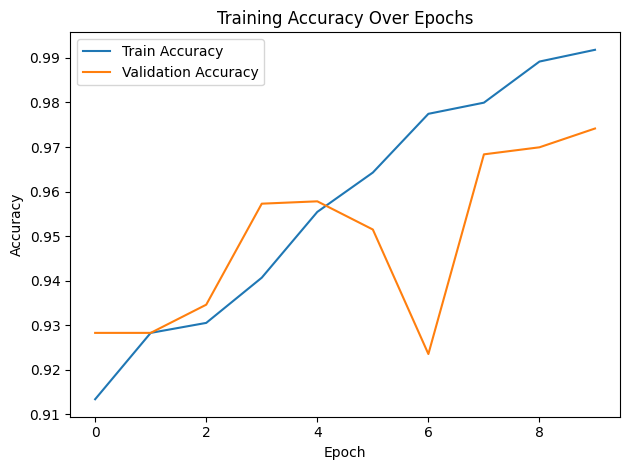

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## Precision - Recall Curve and Threshoold Tuning

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


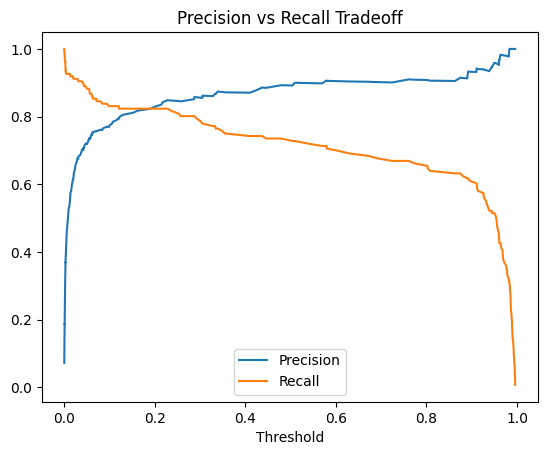

In [ ]:
from sklearn.metrics import precision_recall_curve

y_proba = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot precision-recall vs threshold
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision vs Recall Tradeoff")
plt.show()

In [ ]:
from numpy import argmax

f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal threshold for F1: {best_threshold:.2f}")

Optimal threshold for F1: 0.23


## Final Evaluation @ Optimal Threshold

In [ ]:
y_pred_custom = (y_proba > best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1760
           1       0.85      0.82      0.83       136

    accuracy                           0.98      1896
   macro avg       0.92      0.90      0.91      1896
weighted avg       0.98      0.98      0.98      1896



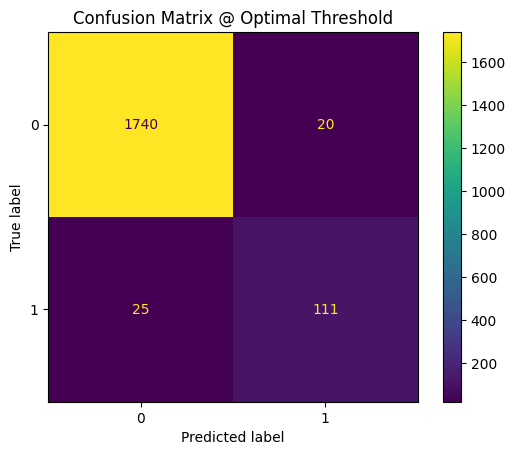

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom)
plt.title("Confusion Matrix @ Optimal Threshold")
plt.show()

In [ ]:
np.save("/content/y_pred_custom.npy", y_pred_custom)

## Save Threshold and Model Artifacts


In [ ]:
with open("/content/decision_threshold.txt", "w") as f:
    f.write(str(best_threshold))

In [ ]:
model.save("/content/rnn_model.keras")
print("Model saved as rnn_model.keras")

log_df = pd.read_csv("/content/training_log.csv")
log_df.to_csv("/content/training_log_v1.csv", index=False)

Model saved as rnn_model.keras


## Predict on New Input

## New Section

In [ ]:
X_input = X_test
y_pred = (model.predict(X_input) > 0.23).astype(int)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
import json

metadata = {
    "model_name": "rnn_model.keras",
    "threshold": float(best_threshold),
    "input_shape": list(X_train.shape[1:]),
    "features_used": structured_features,
    "tokenizer_path": "/content/tokenizer.pkl"
}

with open("/content/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)